# Project 2

## 1. Imports

# Installation of numba to moleng37 environemnt

conda activate moleng37

conda install -n moleng37 numba

conda deactivate

In [1]:
import os
import math 
import time
import numpy as np 
import scipy as sp 
import matplotlib as mpl
import matplotlib.pyplot as plt
import mpl_toolkits as mpl
import copy

#set the random seed generator
np.random.seed(seed = 170786)



## 2. Wrap to periodic boundaries

In [ ]:
# wrapping to box
from numba import njit
@njit

def wrap(r,L):

    if r[0] >= L:
        r[0] -= L
    elif r[0] < 0:
        r[0] += L
    if r[1] >= L:
        r[1] -= L
    elif r[1] < 0:
        r[1] += L
    if r[2] >= L:
        r[2] -= L
    elif r[2] < 0:
        r[2] += L

    return r

wrap([1.2,-0.2, 1.2], 1)

## 3. Minimum image distance between two atoms whose xyz coordinates are held in 3 element vectors r1 and r2

In [ ]:
from numba import njit
@njit(nopython=True)

def dist(r1,r2,L):
    
    halfL = L/2.
    
    dx = r2[0]-r1[0]
    dy = r2[1]-r1[1]
    dz = r2[2]-r1[2]

    if dx >= halfL:
        dx -= L
    elif dx < -halfL:
        dx += L
    if dy >= halfL:
        dy -= L
    elif dy < -halfL:
        dy += L
    if dz >= halfL:
        dz -= L
    elif dz < -halfL:
        dz += L

    return math.sqrt(dx**2+dy**2+dz**2)

dist([0.0,0.0,0.0], [0.0,0.0,0.7], 1)


## 4. Compute the energy between two particles i and j via the LJ potential

In [4]:
# pairwise LJ energy
import numba 
@numba.njit
def E_ij(s,sigma,epsilon):
    
    q6 = (sigma/s)**6
    q12 = q6**2
    
    return 4*epsilon*(q12-q6)

## 5. Pairwise force

In [6]:
# pairwise LJ force
from numba import njit
@njit


def f_ij(r,sigma,epsilon):
    
    s = math.sqrt(r[0]**2+r[1]**2+r[2]**2)
    
    q6 = (sigma/s)**6
    q12 = q6**2
    
    return -(48*epsilon/s**2)*(q12 - 0.5*q6)*r

f_ij(np.array([1,1,1]), .34, 1.65)

array([0.00075515, 0.00075515, 0.00075515])

## 6. Randomly position the N Ar atoms withint he cubic box of side length L avoding collisions between particles at distances closer than sigma

In [ ]:
def init_rand(N,L, sigma):
    atomSites = np.zeros((N,3), dtype = float) #create an array of length N that will store the coordinates of each of the N atoms
    
    atoms = 0 #counter variable
    while atoms != N: #generate new atom location until we have n atoms
        #randomly generate a position
        tempPosition = [np.random.rand()*L, np.random.rand()*L, np.random.rand()*L] #randomly generate position
        
        #store list to calcualte distances
        testDistance = [] #store distances between our randomly generated particle and all other particles already in the atom array
        
        #calculate the distance between the new partical and all other particles
        for row in range(0, N): #calcalute the distances between the present particles and the potential new particle
            r1 = atomSites[row,:]
            r2 = tempPosition
            distance = dist(r1, r2, L)
            testDistance.append(distance>sigma)
            
        #determine if the distance between this particle and all other particles is greater then sigma. if true, append
        if all(testDistance)==True:
            
            atomSites[atoms,:]=np.array(tempPosition)
            atoms+=1
    print("Percent completion=", 100*atoms/N, "%")
    return atomSites

print(init_rand(8, 2.5, 0.34))

## 7. Position the atoms within the cubic box of side length L on a simple cubic crystal lattice.

In [ ]:
def init_xtal(N,L):
    #calcualte all the positions for the atoms in a cubic lattice
    atomDensity = int(np.ceil(N**(1/3))) #determine the number of atoms that can fit along 1 dimension of the box
    interval = L/atomDensity #determine the space between the atoms that would be in the box

    #input the positions into the N,3 array 
    atomSites = np.zeros((N,3), dtype = float) #create an array to store the coordinates of N atoms
    
    atoms = 0 #counter variable 
    
    #loop over all x,y,z dimensions 
    for x in range(0, atomDensity):
        if atoms == N: break #break the code if we have reached the box number of atoms
        for y in range(0, atomDensity):
            if atoms == N: break
            for z in range(0, atomDensity):
                if atoms == N: break
                atomSites[atoms,:] = np.array([(x*interval), (y*interval), (z*interval)]) #the coordinate of the atom is the position in the box times the interval distances between atoms in the box
                atoms += 1 #add to the counter
    print("Percent completion=", 100*atoms/N, "%") #completion statement
    return atomSites

init_xtal(100, 2.5)

## 8. Total Energy

In [9]:
# energy of particle i


from numba import njit
@njit

def E_i(ri,i,xyz,L,sigma,epsilon):
    
    N = xyz.shape[0]
    
    E_i = 0.
    
    for j in range(N):
        if j!=i:
            rj = xyz[j,:]
            d = dist(ri,rj,L)
            E_i += E_ij(d,sigma,epsilon)
    
    return E_i

In [10]:
# energy of system
from numba import njit
@njit


def E_system(xyz,L,sigma,epsilon):
    
    N = xyz.shape[0]
    
    E = 0.
    
    for ii in range(N):
        r1 = xyz[ii,:]
        for jj in range(ii):
            r2 = xyz[jj,:]
            d = dist(r1,r2,L)
            E += E_ij(d,sigma,epsilon)
    
    return E

## 9. Visualization

Percent completion= 100.0 %


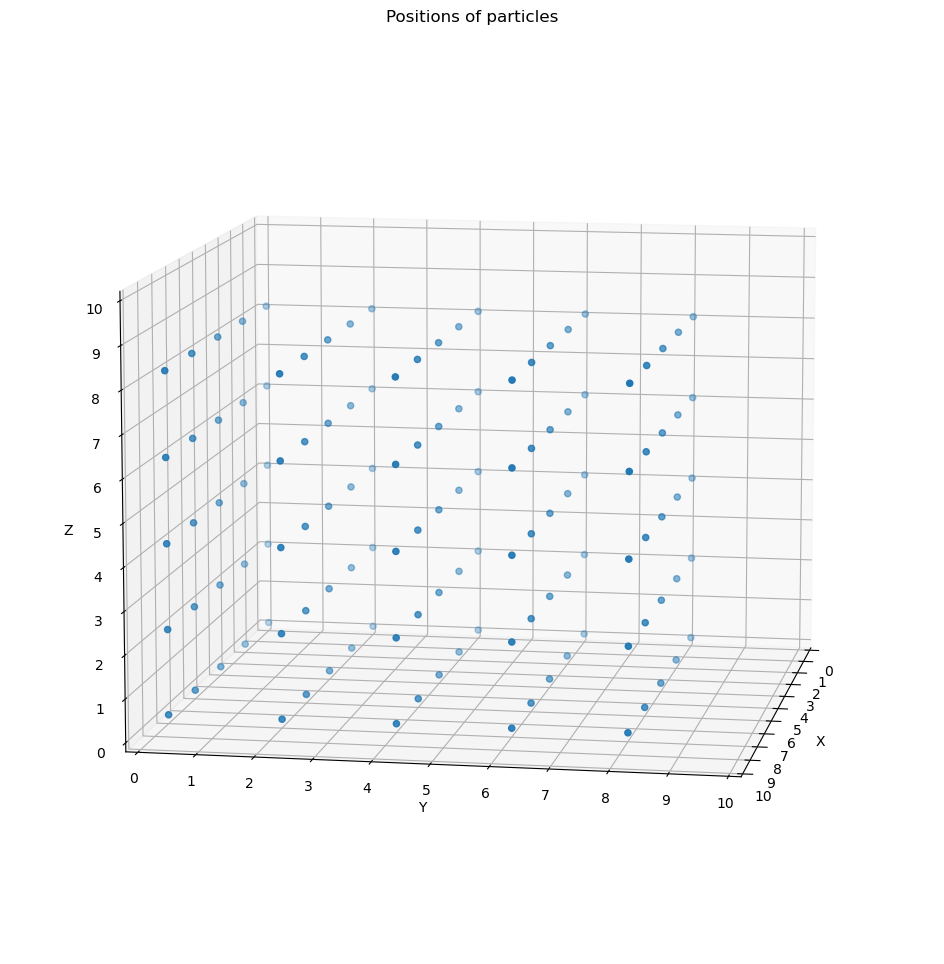

In [11]:
import mpl_toolkits.mplot3d 

def plot_config(xyz, L):
    fig = plt.figure(figsize=(12,12))
    ax = fig.add_subplot(projection="3d")
    
    ticks = np.linspace(0,L, 11) #make even division of 10 ticks for each axis of the box

    ax.set_zticks(ticks)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    
    
    ax.set_xlim(0,L)
    ax.set_ylim(0,L)
    ax.set_zlim(0,L)
    ax.set_xlabel("X")
    ax.set_ylabel("Y")
    ax.set_zlabel("Z")
    
    ax.set_title("Positions of particles")
    
    #coordinate list for xyz coordinates of all the particles
    xs = []
    ys = []
    zs = []
    
    #for each particle in the array, append the xyz coordinate to its respective list
    for row in range(0,xyz.shape[0]):
        xs.append(xyz[row,0])
        ys.append(xyz[row,1])
        zs.append(xyz[row,2])

    #scatter plot the xyz coordinates
    ax.scatter(xs,ys,zs)
    ax.view_init(10, 10)
    plt.show()

xyz = init_xtal(125, 10)

plot_config(xyz, 10)

## 10. Coordinate Write

In [12]:
def xyzWrite(xyz,outfile, writeStyle):
    file = open(str(outfile)+".xyz", writeStyle)
    file.write(str(np.shape(xyz)[0])+'\n') #write the number of atoms at the top 
    file.write("Argon atoms\n")
    for row in range(0,np.shape(xyz)[0]):
        file.write("%5s %f %f %f\n" %("Ar",xyz[row, 0]*10, xyz[row, 1]*10, xyz[row, 2]*10 )) #write into a new line the atom # and the xyz coordinate of the atom
    file.close() #close the file
    file = open(str(outfile)+".xyz", "r") #open the file for reading
    return
xyz = init_xtal(100,2.5)

xyzWrite(xyz=xyz, outfile="coordinates", writeStyle="w")

Percent completion= 100.0 %


## 11. Deployment 

Percent completion= 100.0 %


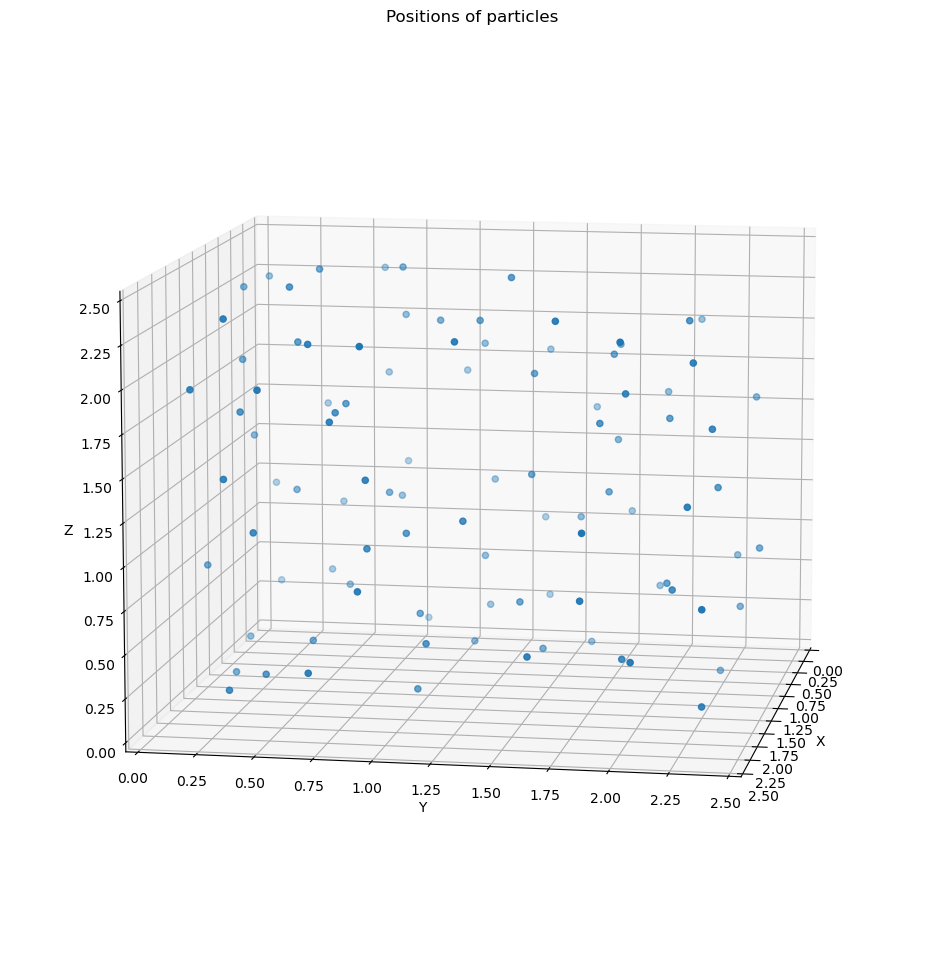

Percent completion= 100.0 %


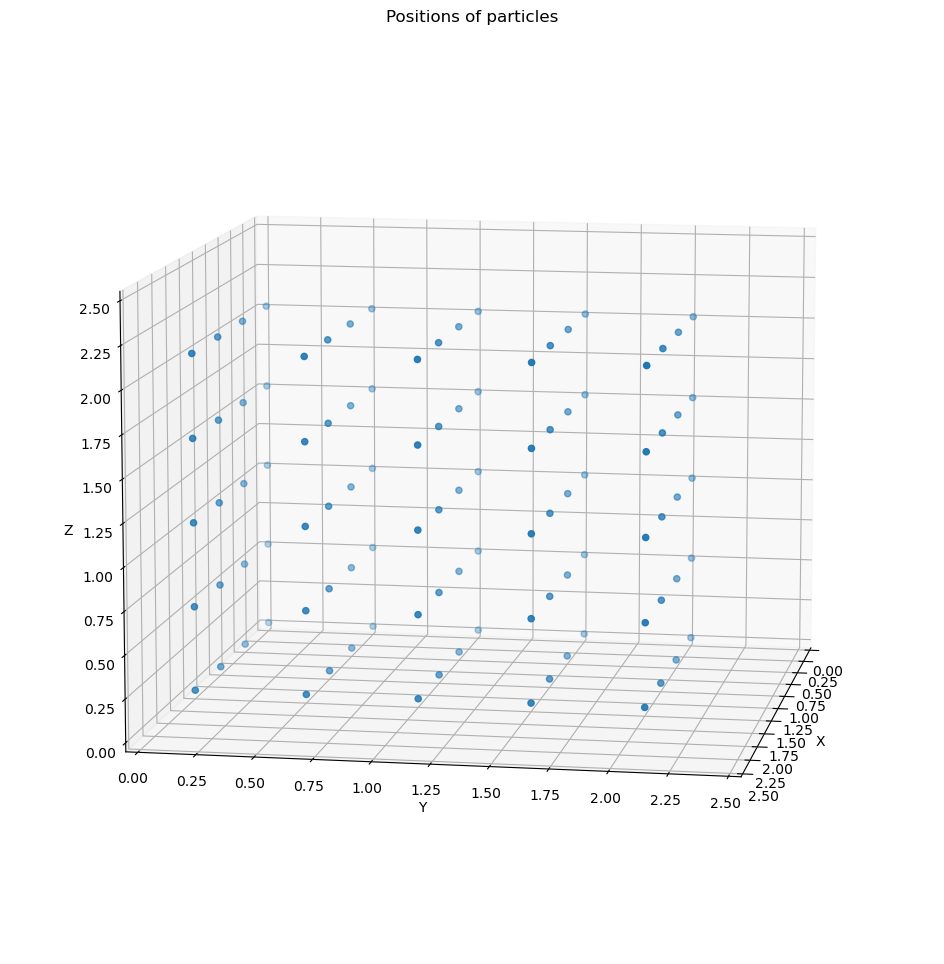

In [13]:
N = 100
L = 2.5 #nm 
sigma = 0.34 #nm 
epsilon = 1.65 #zj 

xyz = init_rand(N,L,sigma)
plot_config(xyz, L)

xyz = init_xtal(N,L)
plot_config(xyz, L)

In [14]:
i = 0 
j = 1 

print('i = %d, j =%d' %(i,j))

dij = dist(xyz[i,:], xyz[j,:], L)
print("dij = %f nm" %dij)

Eij = E_ij(dij, sigma, epsilon)
print("Eij = %f zJ" % Eij)

rij = xyz[j,:] - xyz[i,:]
print("rij (nm):")
print(rij)

fij = f_ij(rij, sigma, epsilon)
print("fij (zJ/nm):")
print(fij)

Ei = E_i(xyz[i,:], i, xyz, L, sigma, epsilon)
print('Ei = %f zJ' %Ei)

E = E_system(xyz, L, sigma, epsilon)
print("E = %f zJ" %E)

i = 0, j =1
dij = 0.500000 nm
Eij = -0.588012 zJ
rij (nm):
[0.  0.  0.5]
fij (zJ/nm):
[0.         0.         6.28197961]
Ei = -3.930762 zJ
E = -221.494854 zJ


# Project 3a

## 1) User Input

In [15]:
T = 298 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 40 #number of atoms 

nSweeps = 5000 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10, #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K


## 2) Main Metropolis Monte Carlo Loop

In [16]:
import sys
import os

def loadingBar(count, total):
    sys.stdout.write("\r" + "Iteration progress for random lattice:" + str(int(count)) + "/" + str(int(total)))



def monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename):
    try:
        os.remove(filename+".xyz")
    except:
        pass
    xyz_initial = copy.deepcopy(xyz)
    
    # loop of the monteCarlo
    sweepCount = 0
    accepts = 0
    trials = 0 
    systemEnergy = []
    acceptanceRatio = []
        
    while sweepCount < nSweeps:

        
        #save the system atom coordinates
        if sweepCount%writeModulus == 0:
            xyzWrite(xyz, filename, "a")
            
        sweepCount += 1
        for i in range(0,np.shape(xyz)[0]):
            trials += 1
            #Select one of the N atoms at random
            randAtomRow = np.random.randint(0,np.shape(xyz)[0])
            randAtom = xyz[randAtomRow,:]
            
            #Apply a random translation
            change = dipSize*np.random.uniform(low=-1, high=1, size=3)
            randAtomNew = np.array([randAtom[0]+change[0], randAtom[1] + change[1], randAtom[2] + change[2]])
            
            #Wrapping trial move to periodic boundaries
            randAtomNew = wrap(randAtomNew, L)

            
            #Evaluation of the energy difference between the original, and trial configurations
            oldEnergySystem = E_i(randAtom, randAtomRow, xyz, L, sigma, epsilon)
            newEnergySystem = E_i(randAtomNew, randAtomRow, xyz, L, sigma, epsilon)

            #Acceptance probability
            B = 1/(k*T)
            x = np.e**(-B*(newEnergySystem-oldEnergySystem))

            #Coordiante change
            if x>np.random.random():
                xyz[randAtomRow,:] = randAtomNew
                accepts += 1
            
            #outputs
            ## print total system potential energy E to screen every printModulus MC sweeps
            
        #Save the system potential energy for printing
        if sweepCount%printModulus == 0: 
            systemEnergy.append(E_system(xyz, L, sigma, epsilon))
            print("Current system energy:", systemEnergy[-1])
            acceptanceRatio.append(accepts/trials)
            print("Current acceptance ratio:", acceptanceRatio[-1])        

        loadingBar(sweepCount, nSweeps)
    print("")
    xyz_final = xyz

    return systemEnergy, acceptanceRatio, xyz_initial, xyz_final

## 3) Production runs

### T= 298 

In [ ]:
T = 298 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 40 #number of atoms 

nSweeps = 5000 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "mc_t=298"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, systemEnergy)
plt.xlabel("Sweep")
plt.ylabel("System Energy")
plt.title("System Energies per 10 Sweeps of atoms")

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per 10 Sweeps of atoms")

#### T=298 initial

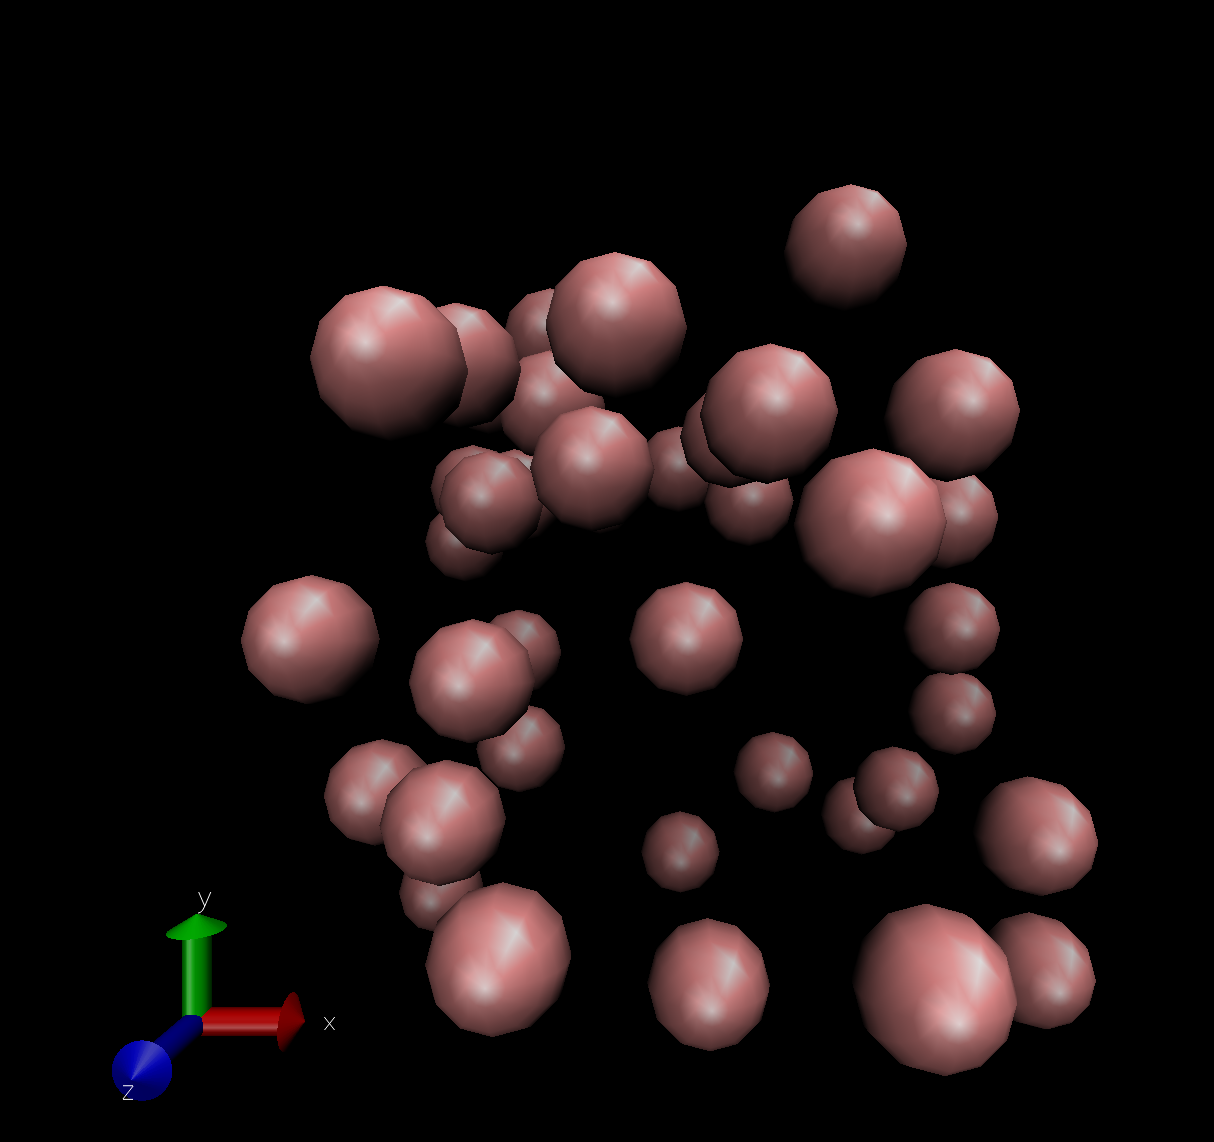

In [18]:
from IPython.display import Image
Image(filename='T298 initial.png') 

#### T = 298 final

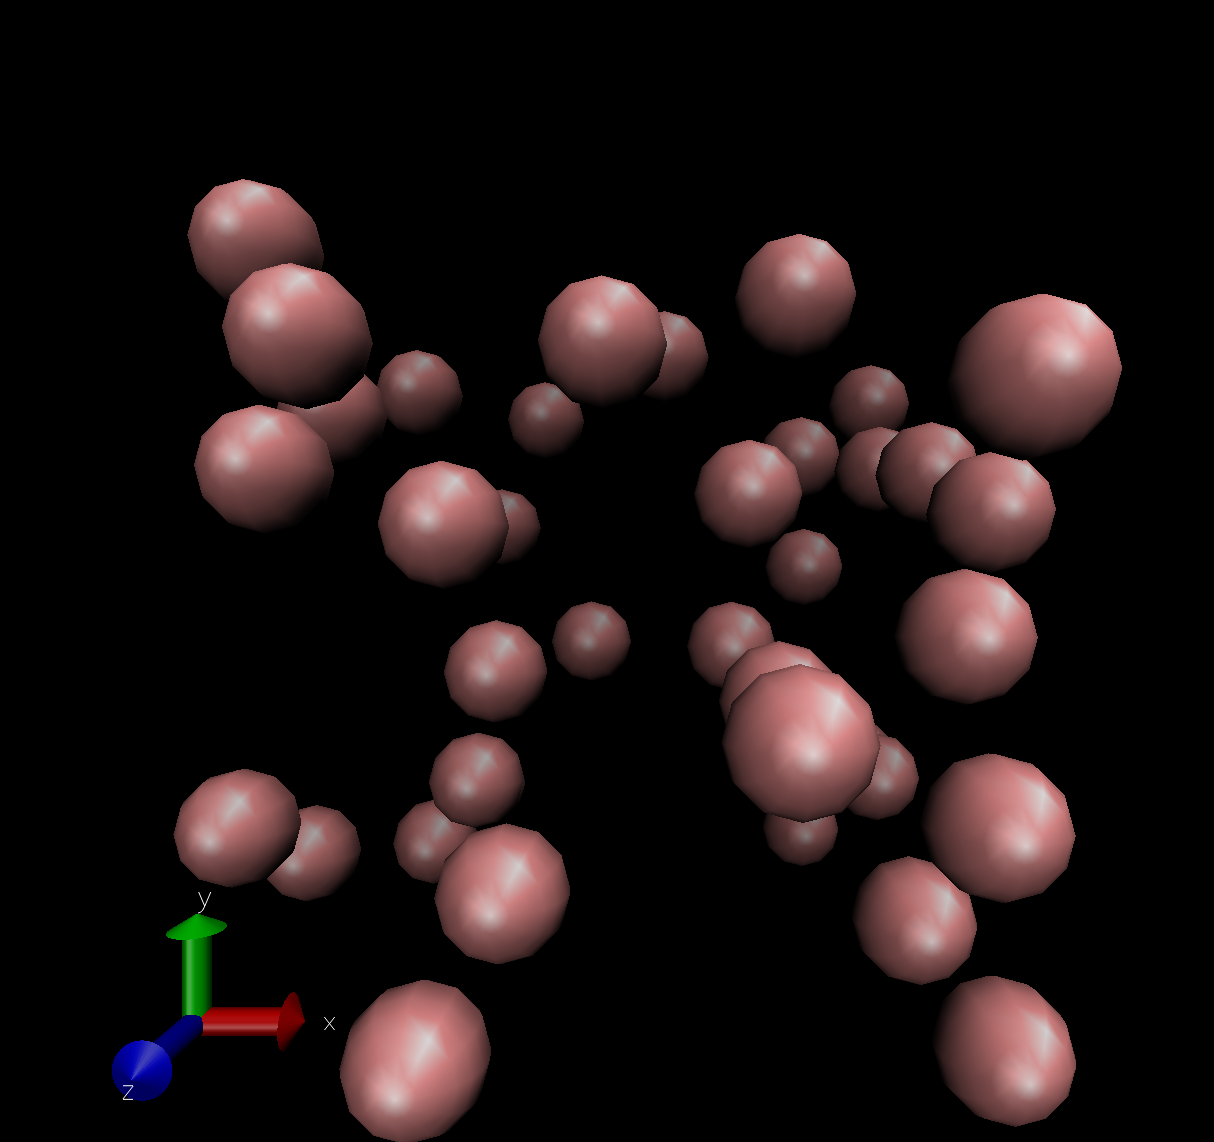

In [19]:
from IPython.display import Image
Image(filename='T298 final.png') 

### T = 50


In [ ]:
T = 50 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 40 #number of atoms 

nSweeps = 5000 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "mc_t=50"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, systemEnergy)
plt.xlabel("Sweep")
plt.ylabel("System Energy")
plt.title("System Energies per 10 Sweeps of atoms")

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per 10 Sweeps of atoms")

#### T = 50 initial

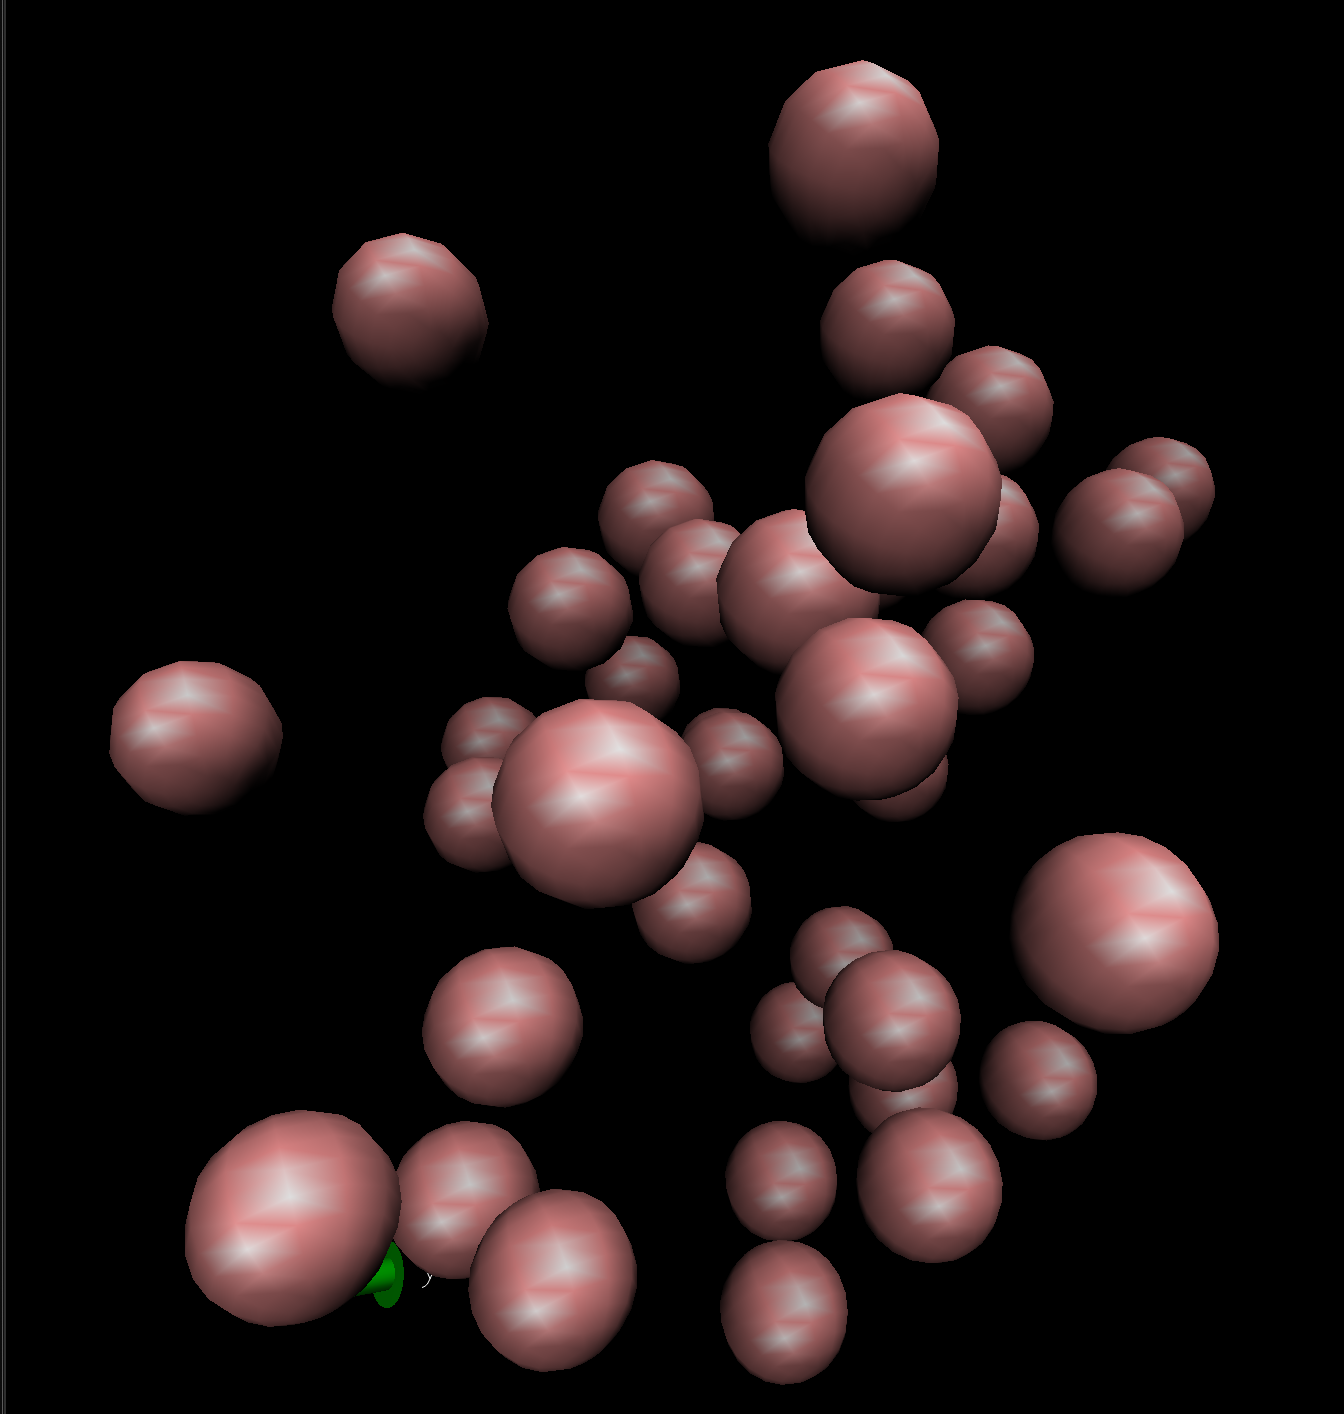

In [21]:
from IPython.display import Image
Image(filename='T50 initial.png') 

#### T = 50 final

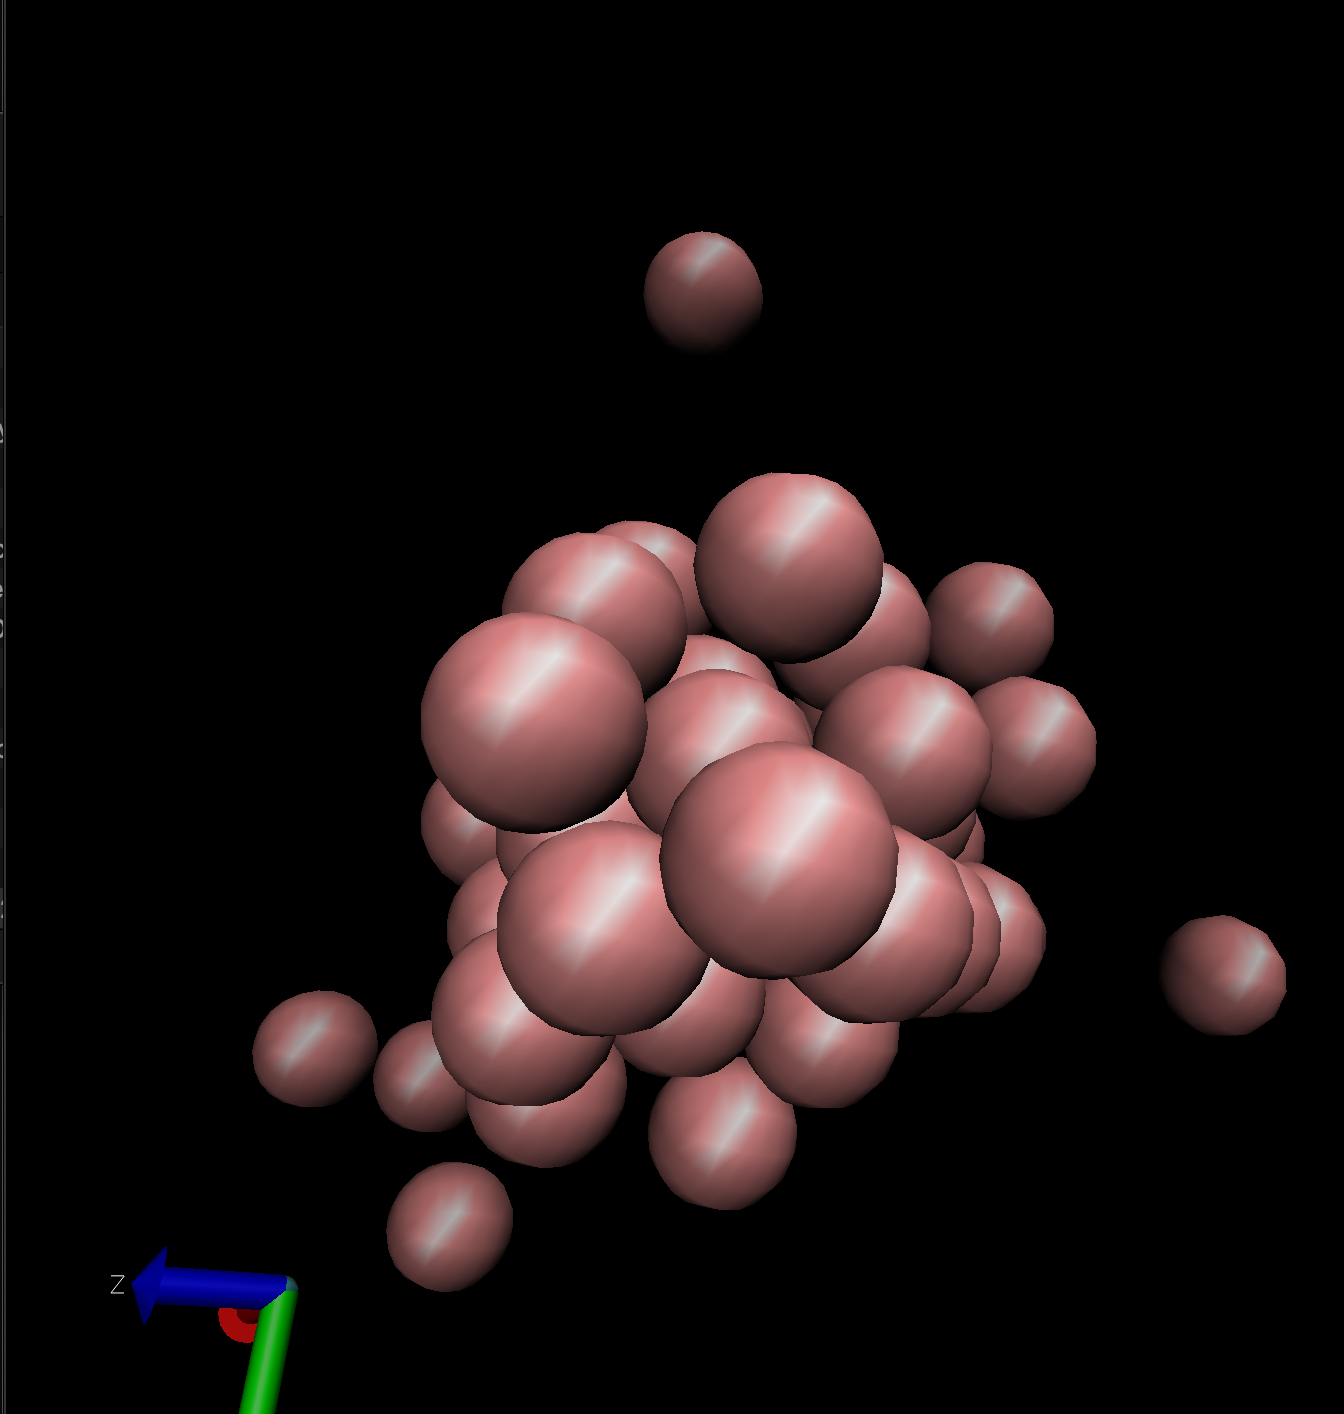

In [22]:
from IPython.display import Image
Image(filename='T50 final.png') 

### Conclusions

At 298 degrees, the Argon atoms remain in a spaced configuration. At 50 degrees, the Argon atoms cluster together and condense into a crystal like structure. This agrees with intution, as one would expect the Argon gas to be a solid at 50 degrees K. 

The energy varies continuously throughout the sweeps at 298 degrees. But at 50 degrees, the energy declines and then converges to a similar values for every successive sweep. 

These occurences are in line with the system behavior, as we expect a cooler system to act with less energy and to be more compact.

# Project 3b

Please see top of jupyter notebook for numba installation instructions

## 1.1 Viral equation of state

In [23]:
from numba import njit
@njit

def pressure(N, L, T, xyz, sigma, epsilon):
    '''
    Output pressure in zj/nm^3
    '''
    
    #calculate parameters
    kB = 1.38064852 * 10**-2 #zJ/K
    v = L**3
    rho = N/v
    pairs = []
    force_pairs = []
    
    #iterate over all non repeated atom pairs 
    for i in range(0, np.shape(xyz)[0]):
        for j in range(i):


            #calcaulte r
            rij = [xyz[i,c] - xyz[j,c] for c in [0,1,2]]
            rij = np.array(wrap(rij, L))
            
            #calcualte force
            fr = np.dot(f_ij(rij, sigma, epsilon), rij)
            force_pairs.append(fr)
                
    
    return float(rho*kB*T - (1/(3*v)) * sum(force_pairs))

N = 40
L = 2.5
T = 298
sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
xyz = init_rand(N, L, sigma)

pressure(N, L, T, xyz, sigma, epsilon)

Percent completion= 100.0 %


10.166126777065209

## 1.2 Pressure calculation

# Pressure in zj/nm^3, and energy in zj

In [24]:
import sys
import os


def loadingBar(count, total):
    sys.stdout.write("\r" + "Iteration progress for random lattice:" + str(int(count)) + "/" + str(int(total)))


def monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename):
    try:
        os.remove(filename+".xyz")
    except:
        pass
    xyz_initial = copy.deepcopy(xyz)
    
    # loop of the monteCarlo
    sweepCount = 0
    accepts = 0
    trials = 0 
    systemEnergy = []
    systemPressure = []
    acceptanceRatio = []
        
    while sweepCount < nSweeps:

        
        #save the system atom coordinates
        if sweepCount%writeModulus == 0:
            xyzWrite(xyz, filename, "a")
            
        sweepCount += 1
        for i in range(0,np.shape(xyz)[0]):
            trials += 1
            #Select one of the N atoms at random
            randAtomRow = np.random.randint(0,np.shape(xyz)[0])
            randAtom = xyz[randAtomRow,:]
            
            #Apply a random translation
            change = dipSize*np.random.uniform(low=-1, high=1, size=3)
            randAtomNew = np.array([randAtom[0]+change[0], randAtom[1] + change[1], randAtom[2] + change[2]], dtype=float)
            
            #Wrapping trial move to periodic boundaries
            randAtomNew = wrap(randAtomNew, L)

            
            #Evaluation of the energy difference between the original, and trial configurations
            oldEnergySystem = E_i(randAtom, randAtomRow, xyz, L, sigma, epsilon)
            newEnergySystem = E_i(randAtomNew, randAtomRow, xyz, L, sigma, epsilon)

            #Acceptance probability
            B = 1/(k*T)
            x = np.e**(-B*(newEnergySystem-oldEnergySystem))

            #Coordiante change"
            if x>np.random.random():
                xyz[randAtomRow,:] = randAtomNew
                accepts += 1
            
            #outputs
            ## print total system potential energy E to screen every printModulus MC sweeps
            
        #Save the system potential energy for printing
        if sweepCount%printModulus == 0: 
            systemEnergy.append(E_system(xyz, L, sigma, epsilon))
            acceptanceRatio.append(accepts/trials)
            systemPressure.append(pressure(np.shape(xyz)[0], L, T, xyz, sigma, epsilon))
            #print("Current acceptance ratio:", acceptanceRatio[-1])      
        loadingBar(sweepCount, nSweeps)
    xyz_final = xyz

    return systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure

In [25]:
T = 298 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 200 #number of atoms 

nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.085 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "3b"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)


Percent completion= 100.0 %
Iteration progress for random lattice:750/750

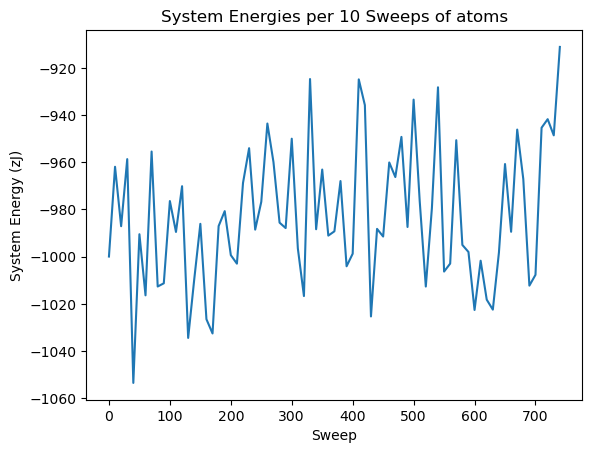

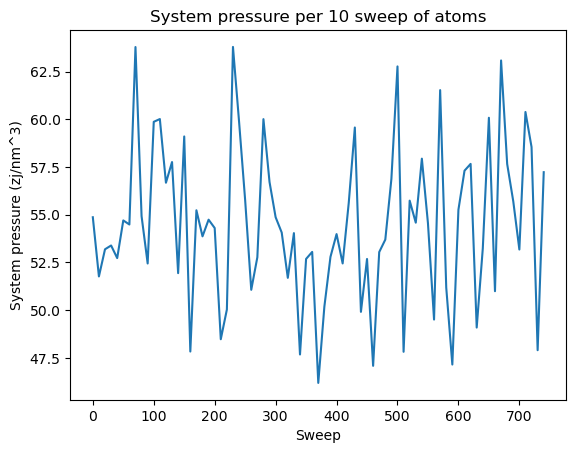

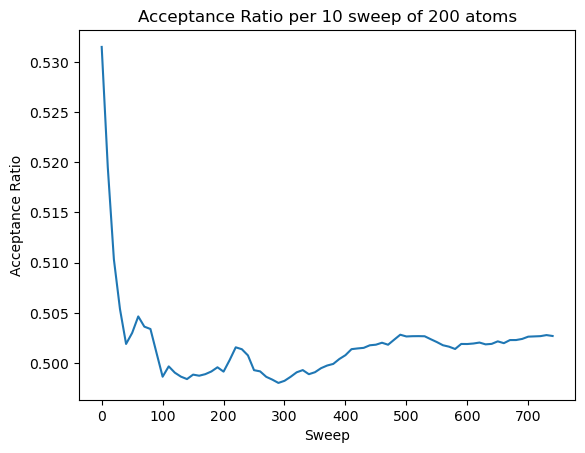

In [26]:
MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, systemEnergy)
plt.xlabel("Sweep")
plt.ylabel("System Energy (zJ)")
plt.title("System Energies per %i Sweeps of atoms" %(printModulus))
plt.show()

plt.figure()
plt.plot(MC_sweeps, systemPressure)
plt.xlabel("Sweep")
plt.ylabel("System pressure (zj/nm^3)")
plt.title("System pressure per %i sweep of atoms" %(printModulus))
plt.ticklabel_format(useOffset=False)    
plt.show()

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per %i sweep of %i atoms" %(printModulus, N))
plt.show()


In [27]:
#Used sweep size of 10
#Sweep list will be 75 long
# If we want the last 500 sweeps, we need to get the last 100 entries
avg_pressure = np.average([systemPressure[i] for i in range(24, 74)])
print("Average pressure (zj/nm^3) over the last 500 sweeps:", avg_pressure)

Average pressure (zj/nm^3) over the last 500 sweeps: 54.223131452080025


Pressures in zj/nm^3
Average pressure for 5 block averages of last 500 sweeps: [55.085477407253734, 52.41836882462239, 53.418847798558126, 54.11697620787588, 56.07598702209]
Average pressure for 5 block St.Dev of last 500 sweeps: [2.9251998490598705, 3.617252324740298, 4.3687244661571825, 4.445090398599125, 4.491041775897948]
Average pressure for 5 block St.E. of last 500 sweeps: [0.9250294134209943, 1.143875621771838, 1.3815119782759886, 1.4056610064918968, 1.4201921078805004]


Text(0.5, 1.0, 'Block averages of system pressure')

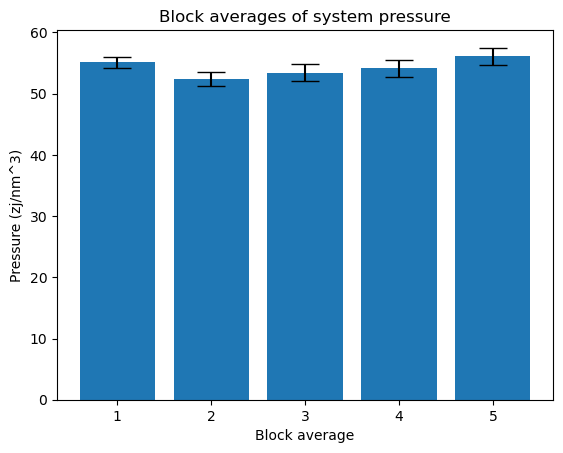

In [28]:
#start is 24
#end is 74

def block_stat(data, start, end, cutSize):
    block_avg_pressure = []
    block_std_pressure = []
    block_ste_pressure = []
    
    for i in range(int(len(data[start:end])/cutSize)):
        dataCut = data[start+cutSize*i:start+cutSize+cutSize*i]
        block_avg_pressure.append(np.average(dataCut))
        block_std_pressure.append(np.std(dataCut))
        block_ste_pressure.append(block_std_pressure[-1]/np.sqrt(cutSize))
    return block_avg_pressure, block_std_pressure, block_ste_pressure

avg, std, ste = block_stat(systemPressure, 24, 74, 10)
print("Pressures in zj/nm^3")
print("Average pressure for 5 block averages of last 500 sweeps:", avg)
print("Average pressure for 5 block St.Dev of last 500 sweeps:", std)
print("Average pressure for 5 block St.E. of last 500 sweeps:", ste)

plt.figure()
plt.bar([1,2,3,4,5], avg, yerr=ste, align="center", ecolor="black", capsize=10)
plt.ylabel("Pressure (zj/nm^3)")
plt.xlabel("Block average")
plt.title("Block averages of system pressure")

## 1.3 Pressure-density relationship

In [29]:
pressure_runs = [0,0,0,0,0]
error_runs = [0,0,0,0,0]

### N = 25

Initial block average runs have pressure in zj/nm^3. Final plot will be in bar, so conversion will be conducted from siluation units

Percent completion= 100.0 %
Iteration progress for random lattice:750/750

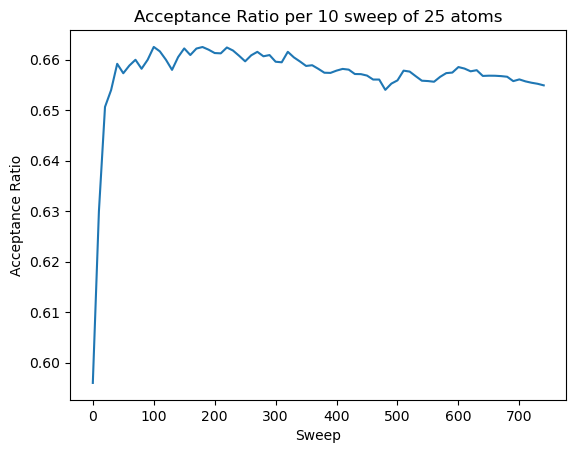

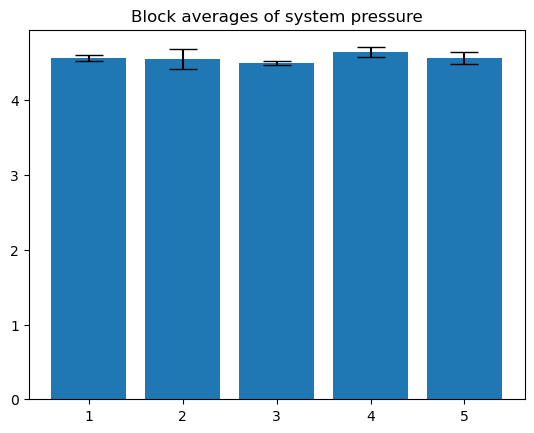

In [30]:
T = 210 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 25 #number of atoms 

nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 1.25 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "3b"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)


MC_sweeps = range(0,nSweeps, printModulus)
avg, std, ste = block_stat(systemPressure, 24, 74, 10)

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per %i sweep of %i atoms" %(printModulus, N))
plt.show()

plt.figure()
plt.bar([1,2,3,4,5], avg, yerr=ste, align="center", ecolor="black", capsize=10)
plt.title("Block averages of system pressure")

pressure_runs[0] = np.average(systemPressure[24:74])
error_runs[0] = np.std(systemPressure[24:74])/np.sqrt(len(systemEnergy[24:74]))


### N = 50

Percent completion= 100.0 %
Iteration progress for random lattice:750/750

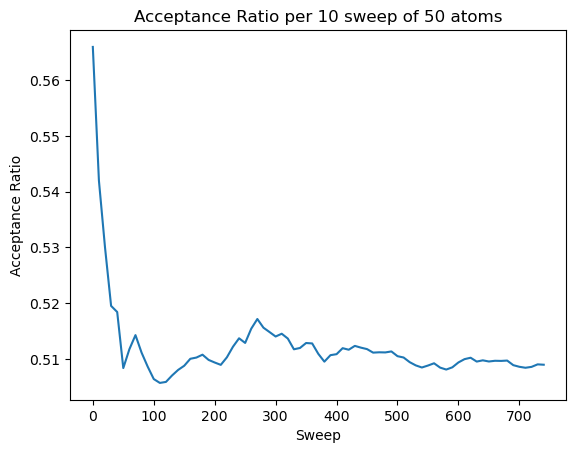

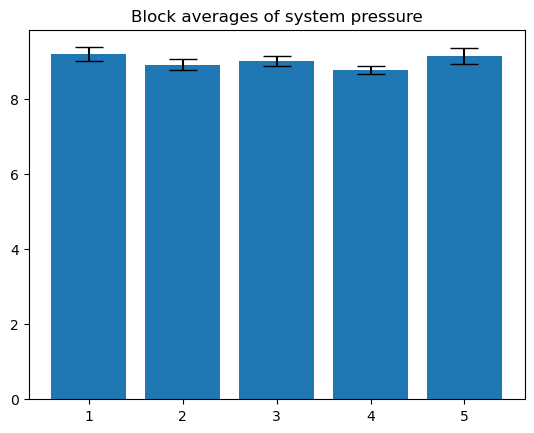

In [31]:
T = 210 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 50 #number of atoms 

nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.45 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "3b"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)


MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per %i sweep of %i atoms" %(printModulus, N))
plt.show()

avg, std, ste = block_stat(systemPressure, 24, 74, 10)
plt.figure()
plt.bar([1,2,3,4,5], avg, yerr=ste, align="center", ecolor="black", capsize=10)
plt.title("Block averages of system pressure")

pressure_runs[1] = np.average(systemPressure[24:74])
error_runs[1] = np.std(systemPressure[24:74])/np.sqrt(len(systemEnergy[24:74]))




### N = 100

Percent completion= 100.0 %
Iteration progress for random lattice:750/750

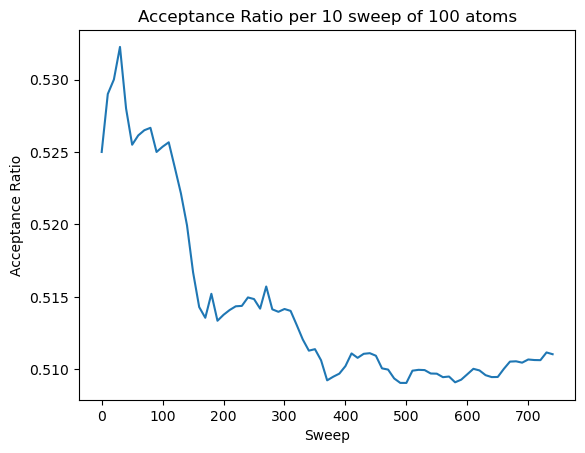

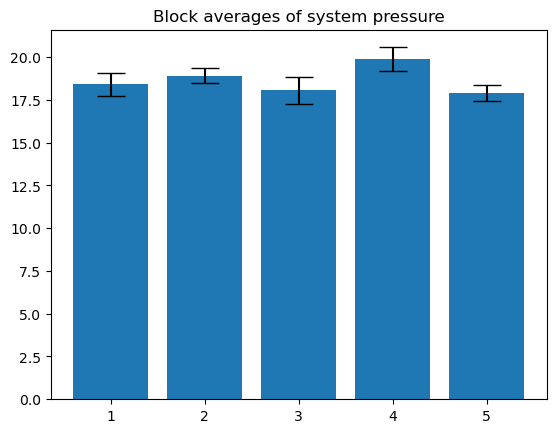

In [32]:
T = 210 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 100 #number of atoms 

nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.165 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "3b"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)


MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per %i sweep of %i atoms" %(printModulus, N))
plt.show()

avg, std, ste = block_stat(systemPressure, 24, 74, 10)
plt.figure()
plt.bar([1,2,3,4,5], avg, yerr=ste, align="center", ecolor="black", capsize=10)
plt.title("Block averages of system pressure")

pressure_runs[2] = np.average(systemPressure[24:74])
error_runs[2] = np.std(systemPressure[24:74])/np.sqrt(len(systemEnergy[24:74]))




### N = 150

Percent completion= 100.0 %
Iteration progress for random lattice:750/750

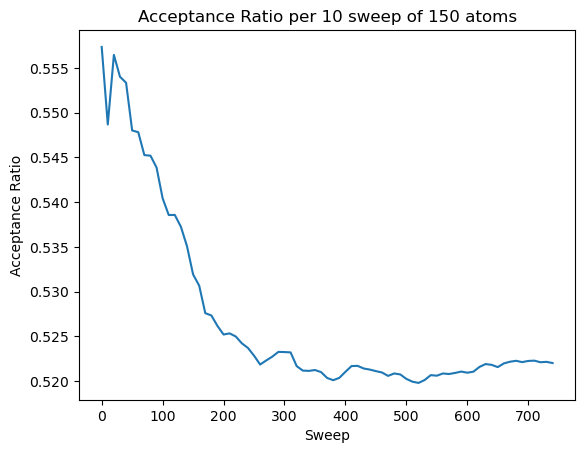

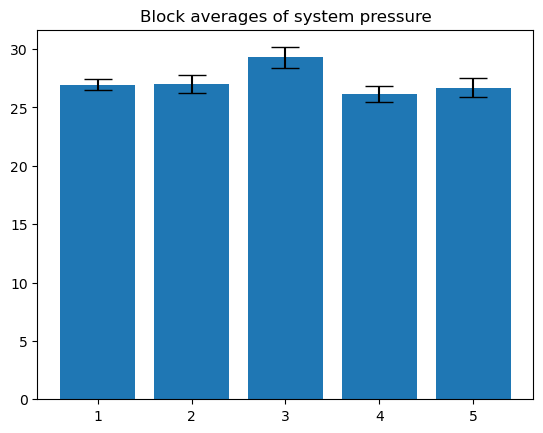

In [33]:
T = 210 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 150 #number of atoms 

nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "3b"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)


MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per %i sweep of %i atoms" %(printModulus, N))
plt.show()

avg, std, ste = block_stat(systemPressure, 24, 74, 10)
plt.figure()
plt.bar([1,2,3,4,5], avg, yerr=ste, align="center", ecolor="black", capsize=10)
plt.title("Block averages of system pressure")

pressure_runs[3] = np.average(systemPressure[24:74])
error_runs[3] = np.std(systemPressure[24:74])/np.sqrt(len(systemEnergy[24:74]))




### N = 200

Percent completion= 100.0 %
Iteration progress for random lattice:750/750

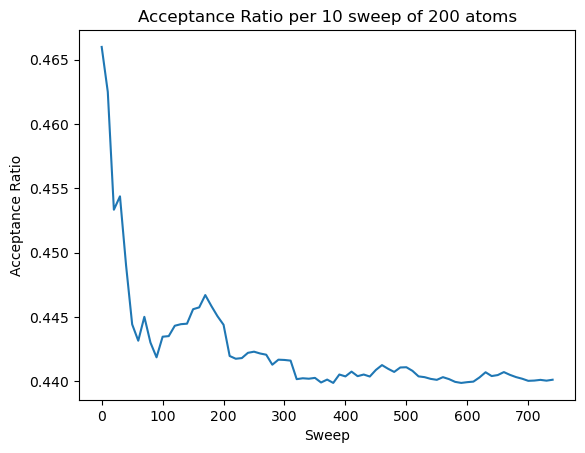

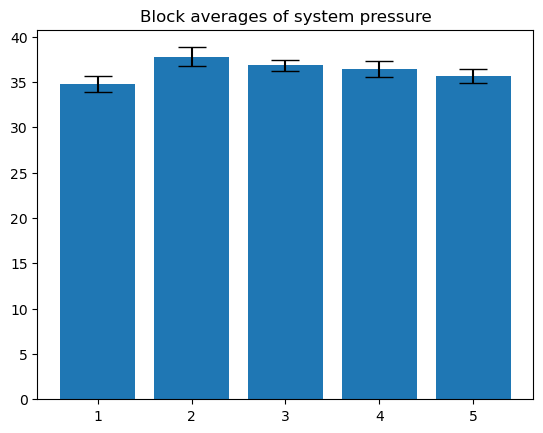

In [34]:
T = 210 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 200 #number of atoms 

nSweeps = 750 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.09 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
kB = 1.38064852 * 10**-2 #zJ/K
filename = "3b"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure = monteCarlo(xyz, L, kB, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename)

MC_sweeps = range(0,nSweeps, printModulus)


MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptance Ratio per %i sweep of %i atoms" %(printModulus, N))
plt.show()

avg, std, ste = block_stat(systemPressure, 24, 74, 10)
plt.figure()
plt.bar([1,2,3,4,5], avg, yerr=ste, align="center", ecolor="black", capsize=10)
plt.title("Block averages of system pressure")

pressure_runs[4] = np.average(systemPressure[24:74])
error_runs[4] = np.std(systemPressure[24:74])/len(systemEnergy[24:74])



### Plot of pressure density relationship

Text(0.5, 0, 'kg/m^3')

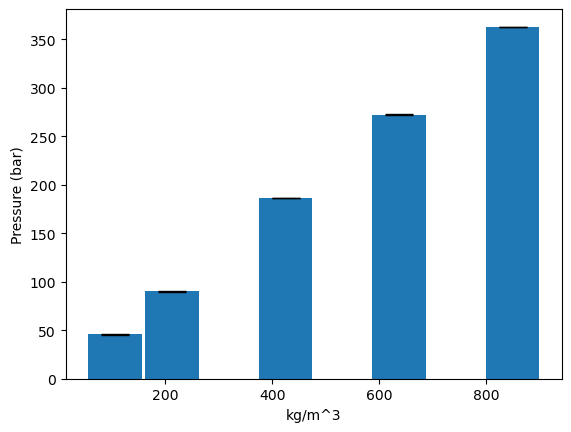

In [35]:
atoms = [25,50,100,150,200]
molarMass = 39.948/1000 #kg/mol
av = 6.02*10**23

density = [(molarMass/av) * i/((L*10**-9)**3) for i in atoms]   
pressure_run_avgs = []
error_run_avgs = []




plt.bar(density, [10*i for i in pressure_runs], yerr=error_runs, align="center", ecolor="black", capsize=10, width = 100)
plt.ylabel("Pressure (bar)")
plt.xlabel("kg/m^3")

# kg * mol * molec
# mol * molec

## 1.4 Equation of State

[40.4516013181407, 72.01674892442108, 124.36073724607292, 216.36352686501425, 533.7911173227028]


Text(0.5, 0, 'kg/m^3')

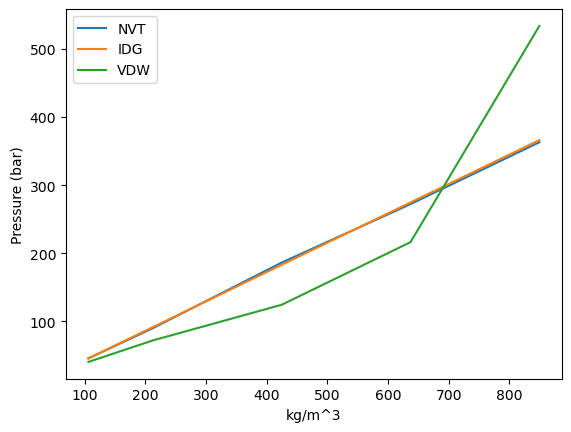

In [36]:
def vdw(a,b,density, R, T):
    pressures = []
    density2 = [i/(39.948/1000) for i in density] #moles/m^3 
    for i in density2:
        top = R * T
        bottom = -b + 1/i
        extra = a*i**2
        
        pressures.append(((top/bottom) - extra))
        
    return pressures

def idg(N,R,T,L):
    pressures = []
    for i in N:
        moles = i/(6.02*10**23)
        v = L**3
        pressures.append((moles*R*T/v))
    return pressures

vdw_pressures = vdw(a=0.1355*10**-5, b=3.201*10**-5, density=density, R=8.2*10**-5, T=210)
idg_pressures = idg([25,50,100,150,200], 8.2*10**-5, 210, 2.5*10**-9)
print(vdw_pressures)
plt.plot(density, [10*i for i in pressure_runs], label = "NVT")
plt.plot(density, idg_pressures, label = "IDG")
plt.plot(density, vdw_pressures, label = "VDW")
plt.legend()
plt.ylabel("Pressure (bar)")
plt.xlabel("kg/m^3")

The molecular simulation pressures agree almost exactly with the pressure calcualted by the ideal gas.

The vander waals equation has repulsive and attractive forces. Repulsive forces dominate at high densities, causing the pressure of the vanderwaals equation to rapidly increase.

The pressure for our molecular simulation appears to not agree as well with the predictions of the vanderwaals, but agrees well with the pressure of the ideal gas law. It is possible that the viral equation of state is not as accurate as compared to the vanderwaals in computing attractive and repulsive terms. Moreover, we may need more simulation sweeps to get better data to show the nature of the viral equation of state's pressure. 

However, we can see from the graph that like the vandwe waals, the viral equation of state of the monte carlo simulation underpredicts at lower pressures, and over predicts at higher presssures, as compared to the ideal gas law.

## 2 NPT Ensemble

In [37]:
import sys
import os


def loadingBar(count, total):
    sys.stdout.write("\r" + "Iteration progress for random lattice:" + str(int(count)) + "/" + str(int(total)))


def monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename, vol, Ptarget):
    try:
        os.remove(filename+".xyz")
    except:
        pass
    xyz_initial = copy.deepcopy(xyz)
    
    B = 1/(k*T)
    
    # loop of the monteCarlo
    sweepCount = 0
    accepts = 0
    accepts2 = 0
    trials = 0 
    trials2 = 0
    systemEnergy = []
    systemPressure = []
    acceptanceRatio = []
    acceptanceRatio2 = []
    Ls = []
    
    while sweepCount < nSweeps:

        
        #save the system atom coordinates
        if sweepCount%writeModulus == 0:
            xyzWrite(xyz, filename, "a")
        
        sweepCount += 1
        for i in range(0,np.shape(xyz)[0]):
            
            #particle change
            trials += 1
            #Select one of the N atoms at random
            randAtomRow = np.random.randint(0,np.shape(xyz)[0])
            randAtom = xyz[randAtomRow,:]
            
            #Apply a random translation
            change = dipSize*np.random.uniform(low=-1, high=1, size=3)
            randAtomNew = np.array([randAtom[0]+change[0], randAtom[1] + change[1], randAtom[2] + change[2]], dtype=float)
            
            #Wrapping trial move to periodic boundaries
            randAtomNew = wrap(randAtomNew, L)

            
            #Evaluation of the energy difference between the original, and trial configurations
            oldEnergySystem = E_i(randAtom, randAtomRow, xyz, L, sigma, epsilon)
            newEnergySystem = E_i(randAtomNew, randAtomRow, xyz, L, sigma, epsilon)

            #Acceptance probability
            
            x = np.e**(-B*(newEnergySystem-oldEnergySystem))
            
            #Coordiante change"
            if x>np.random.random():
                xyz[randAtomRow,:] = randAtomNew
                accepts += 1
            
        if vol ==True:
            trials2 = trials2 + 1
            #volume change
            v = L**3
            
            #apply random volume change
            v_New = v + (v/20) * np.random.uniform(low=-1, high=1)
            L_new = v_New**(1/3)
            
            #scale volume change
            scale = L_new/L
            
            xyz_dv = copy.deepcopy(xyz)
            for i in range(0, np.shape(xyz)[0]):
                xyz_dv[i,0] = xyz[i,0]*scale 
                xyz_dv[i,1] = xyz[i,1]*scale 
                xyz_dv[i,2] = xyz[i,2]*scale 
                
            #calculate acceptance probability
            dU = E_system(xyz_dv, L_new, sigma, epsilon) - E_system(xyz, L, sigma, epsilon)
            
            y = np.e**(-B*(dU+.10*Ptarget*(v_New-v)) + N * np.log(v_New/v) )

            if y>np.random.random():
                xyz = copy.deepcopy(xyz_dv)
                
                L=copy.deepcopy(L_new)
                accepts2 = accepts2 + 1
            #outputs
            ## print total system potential energy E to screen every printModulus MC sweeps
            
        #Save the system potential energy for printing
        if sweepCount%printModulus == 0: 
            systemEnergy.append(E_system(xyz, L, sigma, epsilon))
            acceptanceRatio.append(accepts/trials)
            systemPressure.append(pressure(np.shape(xyz)[0], L, T, xyz, sigma, epsilon))
            #print(pressure(np.shape(xyz)[0], L, T, xyz, sigma, epsilon))
            #print("Current acceptance ratio:", acceptanceRatio[-1])
            acceptanceRatio2.append(accepts2/trials2)
            Ls.append(L)
        loadingBar(sweepCount, nSweeps)
        

    xyz_final = xyz

    return systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure, Ls, acceptanceRatio2

Percent completion= 100.0 %
Iteration progress for random lattice:5000/5000

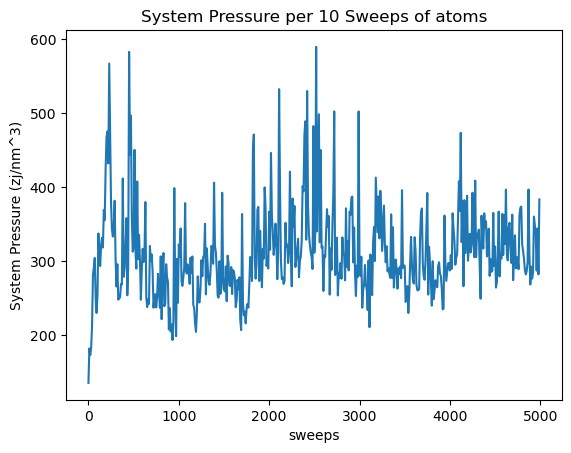

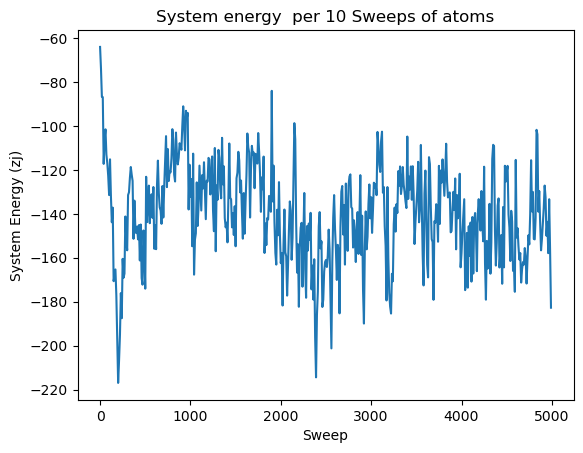

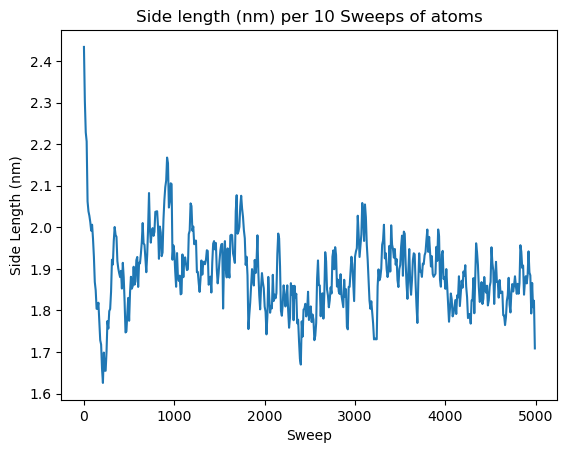

In [38]:
T = 298 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 50 #number of atoms 
P = 300

nSweeps = 5000 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
k = 1.38064852 * 10**-2 #zJ/K
filename = "npt"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure, Ls, acceptanceRatio2 = monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename, vol=True, Ptarget=P)

MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, [10*i for i in systemPressure])
plt.xlabel("Sweep")
plt.ylabel("System Pressure (zj/nm^3)")
plt.title("System Pressure per %i Sweeps of atoms" %(printModulus))
plt.xlabel("sweeps")
plt.show()

plt.figure()
plt.plot(MC_sweeps, systemEnergy)
plt.xlabel("Sweep")
plt.ylabel("System Energy (zj)")
plt.title("System energy  per %i Sweeps of atoms" %(printModulus))
plt.show()


plt.figure()
plt.plot(MC_sweeps, Ls)
plt.xlabel("Sweep")
plt.ylabel("Side Length (nm)")
plt.title("Side length (nm) per %i Sweeps of atoms" %(printModulus))
plt.show()


## 3 Radial Distribution function

In [39]:
import sys
import os


def loadingBar(count, total):
    sys.stdout.write("\r" + "Iteration progress for random lattice:" + str(int(count)) + "/" + str(int(total)))

def gr(xyz_sets, Ls, nSweeps):
    return

def monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename, vol, Ptarget):
    try:
        os.remove(filename+".xyz")
    except:
        pass
    xyz_initial = copy.deepcopy(xyz)
    
    B = 1/(k*T)
    
    # loop of the monteCarlo
    sweepCount = 0
    accepts = 0
    accepts2 = 0
    trials = 0 
    trials2 = 0
    systemEnergy = []
    systemPressure = []
    acceptanceRatio = []
    acceptanceRatio2 = []
    Ls = []
    
    #Calculate radial distribution
    final_distances = []
    final_Ls = []
    
    while sweepCount < nSweeps:

        
        #save the system atom coordinates
        if sweepCount%writeModulus == 0:
            xyzWrite(xyz, filename, "a")
        
        sweepCount += 1
        for i in range(0,np.shape(xyz)[0]):
            
            #particle change
            trials += 1
            #Select one of the N atoms at random
            randAtomRow = np.random.randint(0,np.shape(xyz)[0])
            randAtom = xyz[randAtomRow,:]
            
            #Apply a random translation
            change = dipSize*np.random.uniform(low=-1, high=1, size=3)
            randAtomNew = np.array([randAtom[0]+change[0], randAtom[1] + change[1], randAtom[2] + change[2]], dtype=float)
            
            #Wrapping trial move to periodic boundaries
            randAtomNew = wrap(randAtomNew, L)

            
            #Evaluation of the energy difference between the original, and trial configurations
            oldEnergySystem = E_i(randAtom, randAtomRow, xyz, L, sigma, epsilon)
            newEnergySystem = E_i(randAtomNew, randAtomRow, xyz, L, sigma, epsilon)

            #Acceptance probability
            
            x = np.e**(-B*(newEnergySystem-oldEnergySystem))
            
            #Coordiante change"
            if x>np.random.random():
                xyz[randAtomRow,:] = randAtomNew
                accepts += 1
            
        if vol ==True:
            trials2 = trials2 + 1
            #volume change
            v = L**3
            
            #apply random volume change
            v_New = v + (v/20) * np.random.uniform(low=-1, high=1)
            L_new = v_New**(1/3)
            
            #scale volume change
            scale = L_new/L
            
            xyz_dv = copy.deepcopy(xyz)
            for i in range(0, np.shape(xyz)[0]):
                xyz_dv[i,0] = xyz[i,0]*scale 
                xyz_dv[i,1] = xyz[i,1]*scale 
                xyz_dv[i,2] = xyz[i,2]*scale 
                
            #calculate acceptance probability
            dU = E_system(xyz_dv, L_new, sigma, epsilon) - E_system(xyz, L, sigma, epsilon)
            
            y = np.e**(-B*(dU+.10*Ptarget*(v_New-v)) + N * np.log(v_New/v) )

            if y>np.random.random():
                xyz = copy.deepcopy(xyz_dv)
                
                L=copy.deepcopy(L_new)
                accepts2 = accepts2 + 1
            #outputs
            ## print total system potential energy E to screen every printModulus MC sweeps
            
        #Calcualte the distances between all pairs of atoms
        if (nSweeps-sweepCount)<200:
            for i in range(0,np.shape(xyz)[0]):
                for j in range(0, np.shape(xyz)[0]):
                    if i!=j:
                        distance = dist(xyz[i,:], xyz[j,:], L)
                        final_distances.append(distance)
                        final_Ls.append(L)
                        

        #Save the system potential energy for printing
        if sweepCount%printModulus == 0: 
            systemEnergy.append(E_system(xyz, L, sigma, epsilon))
            acceptanceRatio.append(accepts/trials)
            systemPressure.append(pressure(np.shape(xyz)[0], L, T, xyz, sigma, epsilon))
            #print(pressure(np.shape(xyz)[0], L, T, xyz, sigma, epsilon))
            #print("Current acceptance ratio:", acceptanceRatio[-1])
            acceptanceRatio2.append(accepts2/trials2)
            Ls.append(L)
        loadingBar(sweepCount, nSweeps)
        
    r = np.max(final_Ls) * np.sqrt(3/4)

    dr = r/1000
    
    bins = np.arange(0,r,dr)
    avg_density = N/(np.average(final_Ls))**3

    counts, bins = np.histogram(final_distances, bins)
    
    counts = [counts[i]/(N*4*np.pi*(((dr+bins[i]))**2)*(dr)*200*avg_density) for i in range(0, len(counts))]





    xyz_final = xyz

    return systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure, Ls, acceptanceRatio2, counts, bins

Percent completion= 100.0 %
Iteration progress for random lattice:5000/5000

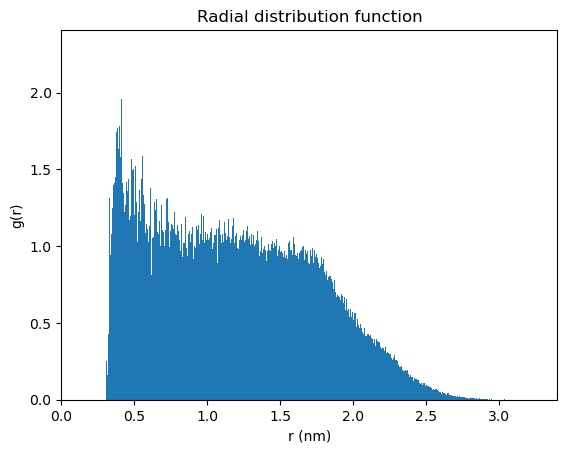

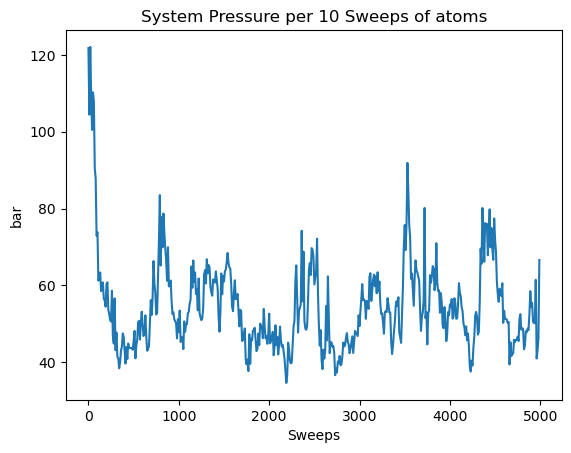

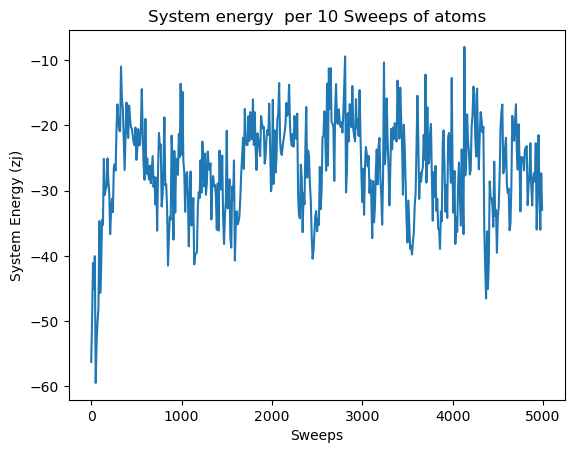

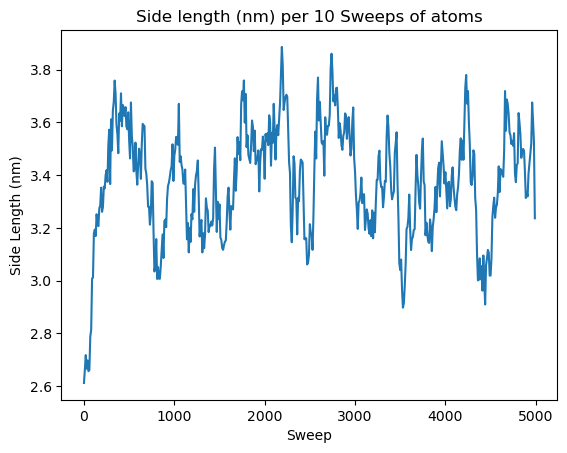

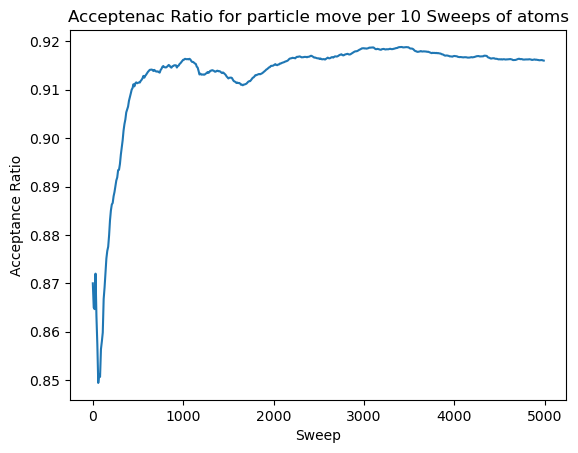

In [40]:
T = 298 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 50 #number of atoms 
Ptarget = 50

nSweeps = 5000 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
k = 1.38064852 * 10**-2 #zJ/K
filename = "npt50"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure, Ls, acceptanceRatio2, counts, bins = monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename, vol=True, Ptarget=Ptarget)

plt.hist(bins[:-1], bins, weights=counts)
plt.xlim(left=0)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.title("Radial distribution function")
plt.show()

MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, [10*i for i in systemPressure])
plt.xlabel("Sweep")
plt.ylabel("System Pressure")
plt.title("System Pressure per %i Sweeps of atoms" %(printModulus))
plt.xlabel("Sweeps")
plt.ylabel("bar")
plt.show()

plt.figure()
plt.plot(MC_sweeps, systemEnergy)
plt.xlabel("Sweeps")
plt.ylabel("System Energy (zj)")
plt.title("System energy  per %i Sweeps of atoms" %(printModulus))
plt.show()


plt.figure()
plt.plot(MC_sweeps, Ls)
plt.xlabel("Sweep")
plt.ylabel("Side Length (nm)")
plt.title("Side length (nm) per %i Sweeps of atoms" %(printModulus))
plt.show()

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptenac Ratio for particle move per %i Sweeps of atoms" %(printModulus))
plt.show()


Percent completion= 100.0 %
Iteration progress for random lattice:5000/5000

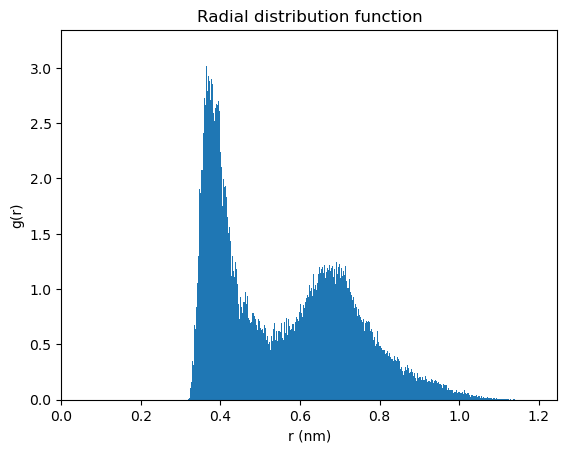

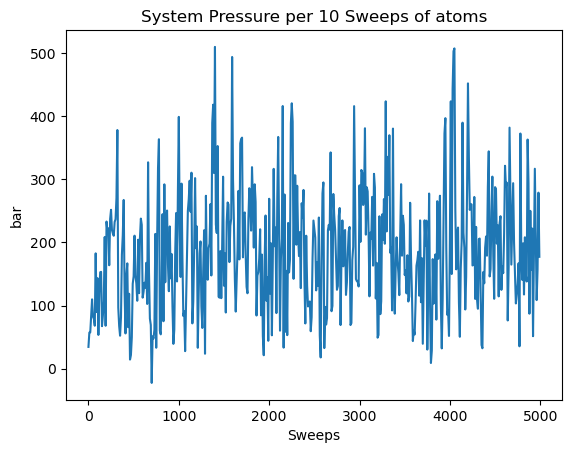

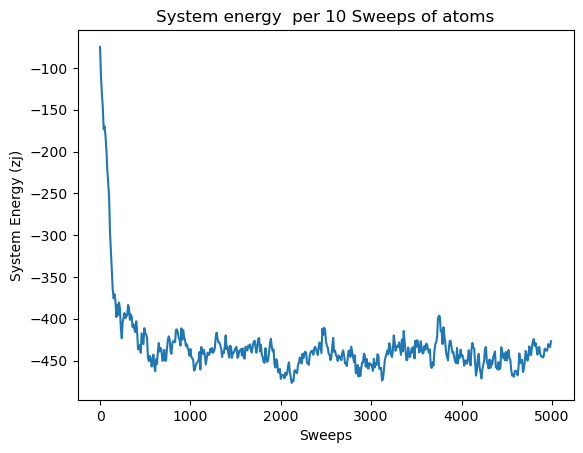

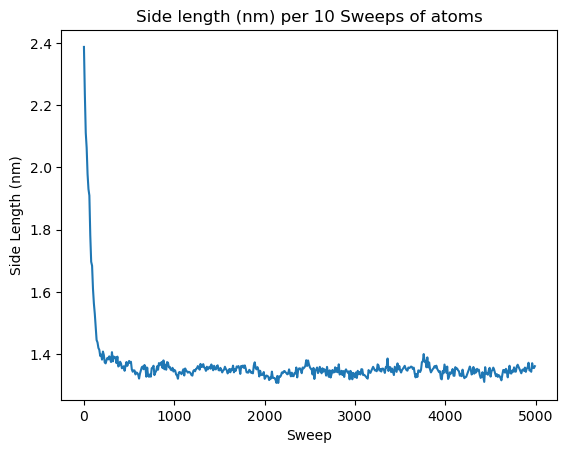

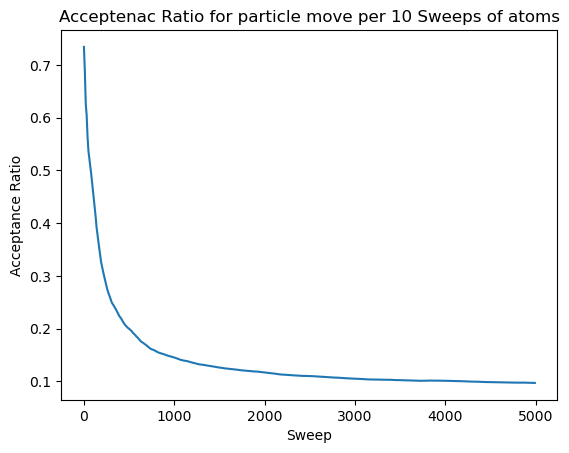

In [41]:
T = 85 #k, temperature 
L = 2.5 #nm, cubic box side length 
N = 50 #number of atoms 
Ptarget = 100

nSweeps = 5000 #number of MC sweeps (1 sweep = N single particle moves)
dipSize = 0.1 #nm, characteristic size of atomic displacement trial moves 
printModulus = 10 #sweeps, freuqency of prints to screen 
writeModulus = 10 #sweeps, frequency of writes to file 

sigma = 0.34 #nm, LJ size parameter for Ar 
epsilon = 1.65 #zj LJ energy parameter 
k = 1.38064852 * 10**-2 #zJ/K
filename = "npt50"

xyz = init_rand(N, L, sigma)

systemEnergy, acceptanceRatio, xyz_initial, xyz_final, systemPressure, Ls, acceptanceRatio2, counts, bins = monteCarlo(xyz, L, k, T, dipSize, nSweeps, printModulus, writeModulus, sigma, epsilon, filename, vol=True, Ptarget=Ptarget)

plt.hist(bins[:-1], bins, weights=counts)
plt.xlim(left=0)
plt.xlabel("r (nm)")
plt.ylabel("g(r)")
plt.title("Radial distribution function")
plt.show()

MC_sweeps = range(0,nSweeps, printModulus)

plt.figure()
plt.plot(MC_sweeps, [10*i for i in systemPressure])
plt.xlabel("Sweep")
plt.ylabel("System Pressure")
plt.title("System Pressure per %i Sweeps of atoms" %(printModulus))
plt.xlabel("Sweeps")
plt.ylabel("bar")
plt.show()

plt.figure()
plt.plot(MC_sweeps, systemEnergy)
plt.xlabel("Sweeps")
plt.ylabel("System Energy (zj)")
plt.title("System energy  per %i Sweeps of atoms" %(printModulus))
plt.show()


plt.figure()
plt.plot(MC_sweeps, Ls)
plt.xlabel("Sweep")
plt.ylabel("Side Length (nm)")
plt.title("Side length (nm) per %i Sweeps of atoms" %(printModulus))
plt.show()

plt.figure()
plt.plot(MC_sweeps, acceptanceRatio)
plt.xlabel("Sweep")
plt.ylabel("Acceptance Ratio")
plt.title("Acceptenac Ratio for particle move per %i Sweeps of atoms" %(printModulus))
plt.show()


The g(r) plot as 50 bar and 298K has a high distribution of molecules at the 0.25 to 1.75 range. Density then sharply falls off.

The g(r) plot at 100 bar and 85K is mostly concentrated at an initial peak at 0.3, and a medium peak at 0.7. 

The first case corresponds to a gas, and the second case corresponds to a solid. Due to the arranged natrue of the solid, they are less likely to freely inhabit all probabilites, but rather situate at positions that correspond to crystal lattice structures. The second case corresponds to a gas, where molecules are more likely to inhibit a greater range of accepted positions.
